In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from helper import AR_generator, manual_ar_process, adf_test, yule_walker, calculate_unit_roots \
    , plot_roots, path_constructor

from setup.config_init import config

folder_path = config['PATH']['path_applications']

# Data manually generated

In [2]:
ar_coeffs = [0.3, -0.7, -0.2, 0.1] 
var = 1

data = manual_ar_process(ar_coeffs, var, 2000)

train_data, test_data = data[:int(len(data)-10)] , data[-10:]

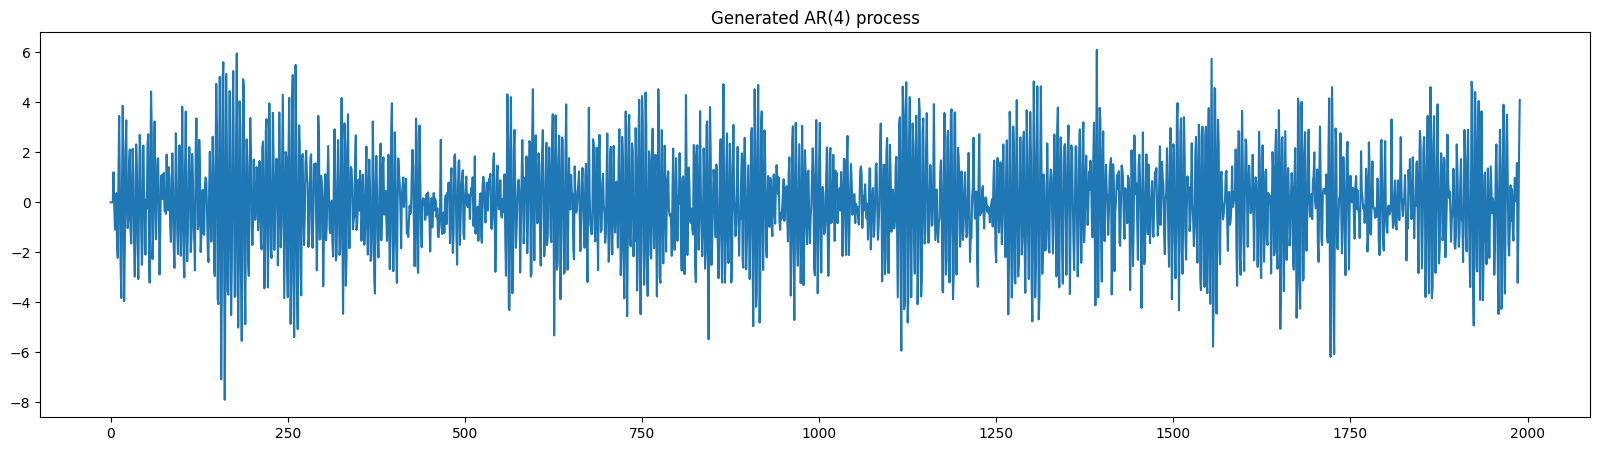

In [3]:
plt.figure(figsize=(20, 5))
plt.title("Generated AR(4) process")
plt.plot(train_data)
plt.savefig(path_constructor(folder_path=folder_path, file_name='AR_process'))

## Stationarity

In [4]:
adf_test(train_data)

Results of Dickey-Fuller Test:


Test Statistic                -1.305851e+01
p-value                        2.070694e-24
#Lags Used                     1.000000e+01
Number of Observations Used    1.979000e+03
Critical Value (1%)           -3.433659e+00
Critical Value (5%)           -2.863002e+00
Critical Value (10%)          -2.567548e+00
dtype: float64

The process is stationary


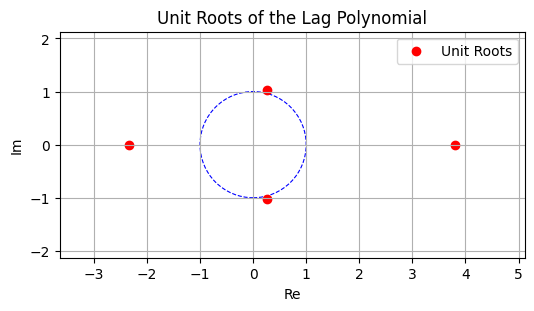

In [5]:
# Calculate roots and unit roots
roots, unit_roots = calculate_unit_roots(ar_coeffs)

# Check for stationarity: All roots should lie outside the unit circle
is_stationary = all(abs(root) > 1 for root in unit_roots)
if is_stationary:
    print("The process is stationary")
else:
    print("The process is not stationary")
    
image = plot_roots(unit_roots)
image.savefig(path_constructor(folder_path=folder_path, file_name='ar2_roots'))

## Plot ACF and PACF

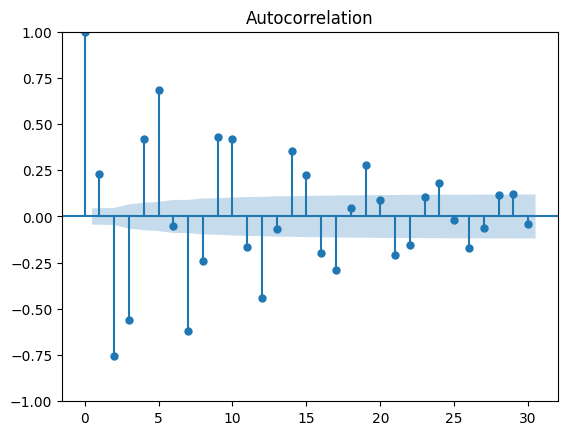

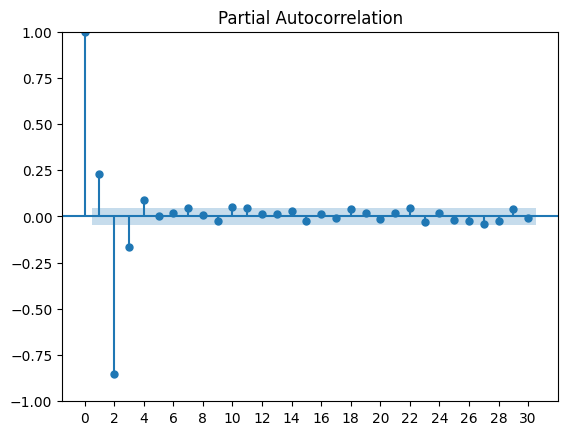

In [6]:
fig1 = plot_acf(train_data, lags=30)
#plt.title("ACF")
plt.show()
fig1.savefig(path_constructor(folder_path=folder_path, file_name='ar2_acf'))

fig = plot_pacf(train_data, lags=30)
#plt.title("PACF")
plt.xticks(np.arange(0, 31, 2))
plt.show()
fig.savefig(path_constructor(folder_path=folder_path, file_name='ar2_acf_pacf'))


## Train models

In [7]:
aic_values = np.array([])
for k in range(1, 8):
    model_k = ARIMA(train_data, order=(k, 0, 0)).fit()
    aic_values = np.append(aic_values, model_k.aic)

/opt/miniconda3/envs/bsc_thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


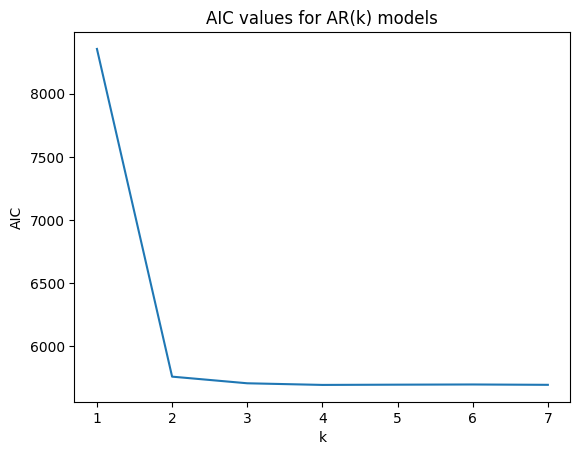

In [8]:
plt.plot(np.arange(1, 8), aic_values)
plt.xticks(np.arange(1, 8))
plt.title("AIC values for AR(k) models")
plt.xlabel("k")
plt.ylabel("AIC")
plt.savefig(path_constructor(folder_path=folder_path, file_name='values_aic'))

In [9]:
f'For k={aic_values.argmin() + 1} the AIC value is the smallest'

'For k=4 the AIC value is the smallest'

## Check residuals

In [10]:
model = ARIMA(train_data, order=(4, 0, 0)).fit()

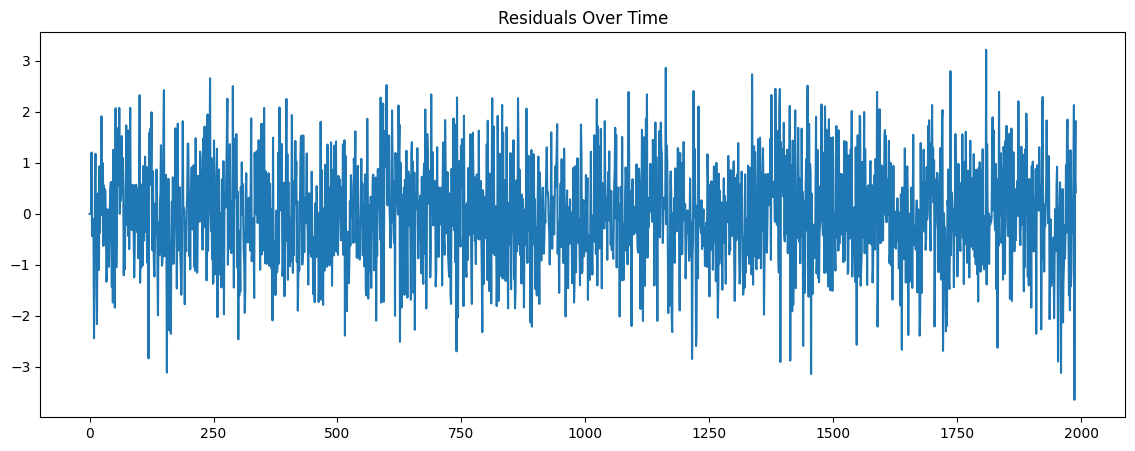

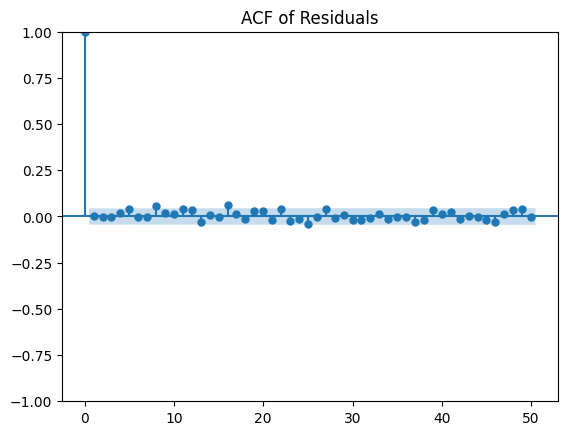

In [11]:
residuals = model.resid
plt.figure(figsize=(14, 5))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.show()

plot_acf(residuals, lags=50)
plt.title("ACF of Residuals")
plt.show()

## Compare parameters

In [12]:
print(ar_coeffs ,var)
model.summary()

[0.3, -0.7, -0.2, 0.1] 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1990
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -2841.849
Date:                Thu, 06 Feb 2025   AIC                           5695.698
Time:                        18:47:23   BIC                           5729.273
Sample:                             0   HQIC                          5708.029
                               - 1990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.015     -0.119      0.905      -0.031       0.027
ar.L1          0.2979      0.022     13.678      0.000       0.255       0.341
ar.L2         -0.7162      0.023    -30.912      0.000      -0.762      -0.671
ar.L3         -0.1891      0.023     -8.375      0.000      -0.233      -0.145
ar.L4          0.0866      0.023      3.745      0.000       0.041       0.132
sigma2         1.0170      0.032     31.424      0.000       0.954       1.080
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.54
Prob(Q):                              1.00   Prob(JB):                         0.77
Heteroskedasticity (H):               1.16   Skew:                            -0.04
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

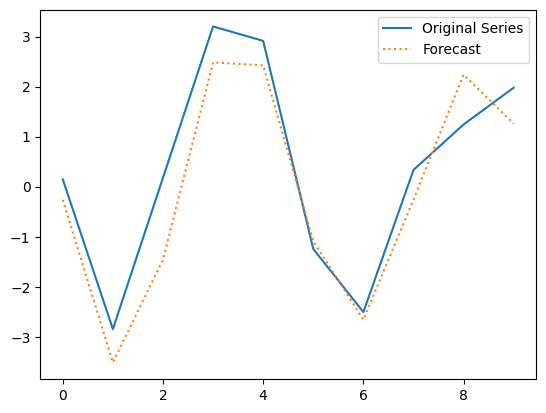

In [13]:
forecast = model.get_forecast(steps=10)
forecast_values = forecast.predicted_mean

# Plot
plt.plot(test_data, label="Original Series")
plt.plot(forecast_values, label="Forecast", linestyle="dotted")
plt.legend()
plt.savefig(path_constructor(folder_path=folder_path, file_name='statsmodels_forecast'))
plt.show()

## Forecast with the estimated parameters from Yule-Walker

In [14]:
estimators, est_var = yule_walker(train_data, 4)
print(f'Estimated parameters: {estimators}\nEstimated variance: {est_var}')

Estimated parameters: [ 0.30028751 -0.71572738 -0.18790675  0.08849309]
Estimated variance: 1.0141314675020396


In [15]:
estimated_noise = np.random.normal(0, np.sqrt(est_var), 14)
new_predicted = np.zeros(14)
new_predicted[:4] = train_data[-4:]

for k in range(4,14):
    new_predicted[k] = sum(estimators[i] * new_predicted[k-i-1] for i in range(4)) + estimated_noise[k]

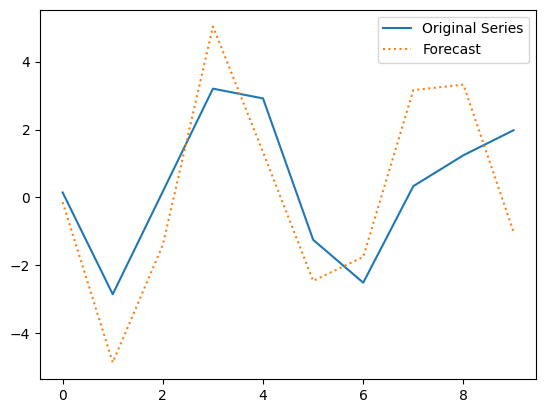

In [16]:
plt.plot(test_data, label="Original Series")
plt.plot(new_predicted[4:], label="Forecast", linestyle="dotted")
plt.legend()
plt.savefig(path_constructor(folder_path=folder_path, file_name='yule_walker_forecast'))
plt.show()